In [3]:
# Evidence of the role of critical developmental period in Sudden Infant Death Syndrome
# Malgorzata Habich 1, Piotr Zielenkiewicz 1, Leszek Paczek 1,2, Pawel Szczesny 1*
#1 Institute of Biochemistry and Biophysics Polish Academy of Sciences, Warsaw, Poland
#2 Department of Immunology, Transplantology, and Internal Diseases, Medical University of Warsaw, Warsaw, Poland
#* Corresponding author email: szczesny.pawel@gmail.com

In [4]:
import os
import re
import pandas as pd
import itertools
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from collections import defaultdict, Counter
from collections import Counter
from scipy.stats import chisquare
plt.rcParams['figure.figsize'] = [20, 10]
sns.set_context("poster")

import json
import requests


In [5]:
years = [1986,1987,1988,1989,1990,1991,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005]

In [6]:
def parse_year(year_file):
    a = pd.read_csv(year_file,sep=";")
    a["pos_start"]-=1
    a["pos_end"] = a["pos_start"] + a["len"]
    return a

In [7]:
field_list = []
for y in years:
    field_list.append(parse_year("./"+str(y)+".txt"))

In [8]:
dirct = [x for x in os.listdir("./datazip/") if "zip" not in x]
files = dict([(x, os.listdir("./datazip/"+x)) for x in dirct])
parse = [x for x in os.listdir("./") if "txt" in x]
num = dict([(re.search("[0-9]+",k).group(0), ["./datazip/"+k+"/"+x for x in files[k] if "num" in x.lower()]) for k in files])
for year in num:
    for p in range(len(parse)):
        if parse[p][2:4] == year:
            num[year].append("./"+parse.pop(p))
            break

In [9]:
def meng_col(names):
    men_names = []
    z = 0
    for i in names:
        if i in men_names:
            men_names.append(i+"-"+str(z))
            z+=1
        else:
            men_names.append(i)
    return men_names

In [10]:
lst = ["GESTAT" , "COMBGEST", #prematurity
       "CIGAR6" , "UCIG_REC6", # cigaretts
       "ALCOHOL", #alcohol
       "AGED","AGER76", #age of death
       "UC0D","UC0D9", #death code
       "SEX","CSEX_01","CSEX", #sex
       "DTHMON","DOD_MM", #month of death
       "BIRMON","DOB_MM", #month of birth
       "BRTHWGT","DBIRWT","DBWT", #birth weight
      "BIRYR","DOB_YY", #year of birth
      "LUNG", #lung disease
      "MAGER8", # mother age
      "MEDUC6",  # mother education
       "STOCCFIPD_88","STOCCFIPD_02", #state
      "CNTOCFIPD"] # county

full_data = pd.DataFrame()
for i in years:
    print(i)
    parsed_year = parse_year("./"+str(i)+".txt")
    num_file = num[str(i)[-2:]][0]
    data_year = pd.read_fwf(num_file,names=meng_col(parsed_year["field"]),widths=parsed_year["len"],dtype="str")
    cutted = data_year[[c for c in data_year.columns if c in lst]]
    print([c for c in data_year.columns if c in lst])
    full_data = full_data.append(cutted,sort=False,ignore_index=True)

1986
['BIRYR', 'CSEX_01', 'GESTAT', 'DBIRWT', 'STOCCFIPD_88', 'CNTOCFIPD', 'AGER76', 'UC0D9']
1987
['BIRYR', 'CSEX_01', 'GESTAT', 'DBIRWT', 'STOCCFIPD_88', 'CNTOCFIPD', 'AGER76', 'UC0D9']
1988
['BIRYR', 'CSEX_01', 'GESTAT', 'DBIRWT', 'STOCCFIPD_88', 'CNTOCFIPD', 'AGER76', 'UC0D9']
1989
['BIRYR', 'MAGER8', 'MEDUC6', 'BIRMON', 'GESTAT', 'CSEX_01', 'DBIRWT', 'LUNG', 'CIGAR6', 'ALCOHOL', 'AGED', 'UC0D9', 'STOCCFIPD_02', 'CNTOCFIPD', 'DTHMON']
1990
['BIRYR', 'MAGER8', 'MEDUC6', 'BIRMON', 'GESTAT', 'CSEX_01', 'DBIRWT', 'LUNG', 'CIGAR6', 'ALCOHOL', 'AGED', 'UC0D9', 'STOCCFIPD_02', 'CNTOCFIPD', 'DTHMON']
1991
['BIRYR', 'MAGER8', 'MEDUC6', 'BIRMON', 'GESTAT', 'CSEX_01', 'DBIRWT', 'LUNG', 'CIGAR6', 'ALCOHOL', 'AGED', 'UC0D9', 'STOCCFIPD_02', 'CNTOCFIPD', 'DTHMON']
1995
['BIRYR', 'MAGER8', 'MEDUC6', 'GESTAT', 'CSEX_01', 'DBIRWT', 'LUNG', 'CIGAR6', 'ALCOHOL', 'BIRMON', 'AGED', 'UC0D9', 'STOCCFIPD_02', 'CNTOCFIPD', 'DTHMON']
1996
['BIRYR', 'MAGER8', 'MEDUC6', 'GESTAT', 'CSEX_01', 'DBIRWT', 'LUNG', 

In [11]:
full_data['GESTAT'].update(full_data.pop('COMBGEST'))
full_data['CIGAR6'].update(full_data.pop('UCIG_REC6'))
full_data['DTHMON'].update(full_data.pop('DOD_MM'))
full_data['BIRMON'].update(full_data.pop('DOB_MM'))
full_data['BRTHWGT'].update(full_data.pop('DBIRWT'))
full_data['BRTHWGT'].update(full_data.pop('DBWT'))
full_data['BIRYR'].update(full_data.pop('DOB_YY'))

full_data.MAGER8 = full_data.MAGER8.astype(float)
full_data.LUNG = full_data.LUNG.astype(float)
full_data.BRTHWGT = full_data.BRTHWGT.astype(float)
full_data.BIRYR = full_data.BIRYR.astype(float)
full_data.DTHMON = full_data.DTHMON.astype(float)
full_data.BIRMON = full_data.BIRMON.astype(float)
full_data.CIGAR6 = full_data.CIGAR6.astype(float)
full_data.GESTAT = full_data.GESTAT.astype(float)
full_data.ALCOHOL = full_data.ALCOHOL.astype(float)
full_data.MEDUC6 = full_data.MEDUC6.astype(float)

In [12]:
# sex
full_data["SEX"] = full_data["SEX"].map({"M":1,"F":2})
full_data.describe(include="all")
full_data['SEX'].update(full_data.pop('CSEX_01'))
full_data['SEX'].update(full_data.pop('CSEX'))

In [13]:
# age
def AGEDtoAGER76(number):
    if pd.isnull(number):
        return number
    number = int(number)
    if number < 28:
        return number
    return int(np.floor(number/7))+24
full_data["AGED"] = full_data["AGED"].apply(AGEDtoAGER76)
full_data["AGER76"] = full_data["AGER76"].apply(lambda x: x if pd.isnull(x) else int(x))
full_data['AGER76'].update(full_data.pop('AGED'))

In [14]:
#prematurity
full_data["GESTAT"].replace({99:np.nan})
full_data["GESTAT"] = full_data.GESTAT.astype(float)

In [15]:
# age 2 -> age in weeks
def AGER76toAGEINW(number):
    if pd.isnull(number):
        return number
    number = int(number)
    if number < 28:
        return int(number/7)
    return number-24

full_data["AGEINW"]= full_data["AGER76"].apply(AGER76toAGEINW)

In [16]:
# state
st88to02 = {1: 1, 2: 2, 3: 4, 4: 5, 5: 6, 6: 8, 7: 9,
            8: 10, 9: 11, 10: 12, 11: 13, 12: 15, 13: 16,
            14: 17, 15: 18, 16: 19, 17: 20, 18: 21, 19: 22,
            20: 23, 21: 24, 22: 25, 23: 26, 24: 27, 25: 28,
            26: 29, 27: 30, 28: 31, 29: 32, 30: 33, 31: 34,
            32: 35, 33: 36, 34: 37, 35: 38, 36: 39, 37: 40,
            38: 41, 39: 42, 40: 44, 41: 45, 42: 46, 43: 47,
            44: 48, 45: 49, 46: 50, 47: 51, 48: 53, 49: 54,
            50: 55, 51: 56, 53: None, 54: None, 55: None, 56: None, 57: None, 58: None, 60: None}


#"STOCCFIPD_88","STOCCFIPD_02"
full_data["STOCCFIPD"] = full_data["STOCCFIPD_88"].apply(lambda x: st88to02[float(x)] if float(x) in st88to02 else None)
full_data["STOCCFIPD"].update(full_data["STOCCFIPD_02"].apply(lambda x: x if pd.isnull(x) else int(x)))

full_data = full_data.drop(["STOCCFIPD_88", "STOCCFIPD_02"],axis=1)

In [17]:
#county
full_data["CNTOCFIPD"] =  full_data["CNTOCFIPD"].astype(float)
full_data["FIPS"] = full_data["STOCCFIPD"].map('{0:02g}'.format) + full_data["CNTOCFIPD"].map('{0:03g}'.format)
full_data["FIPS"] = full_data["FIPS"].replace({'.*nan.*': None}, regex=True)

In [18]:
#icd9 E recode
full_data["UC0D9"] = full_data["UC0D9"].apply(lambda x: 'E' + x if isinstance(x, str) and  (len(str(x)) == 3) else x)
full_data.to_csv("harmz_no_deathcode.csv")

In [19]:
data_cdc = pd.read_csv("./harmz_no_deathcode.csv", index_col=0,dtype={"UC0D9":"object"})
translate_table = pd.read_csv("./2018_I10gemR95.txt",delimiter=" ",names=["icd10", "icd9","code"])
icd9_unique_codes = data_cdc["UC0D9"].dropna().unique()
icd10_unique_codes = data_cdc["UC0D"].dropna().unique()


/home/h/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
icd_9_to_10 = []

for x in icd9_unique_codes:
    t = set([c[:4] for c in translate_table[translate_table.icd9.str.contains(r'^'+x)].icd10])


    if len(t) == 0:
        t = set([c[:3] for c in translate_table[translate_table.icd9.str.contains(r'^'+x[:3])].icd10])
    
    icd_9_to_10.append((x,t))

    icd_10_to_9 = []

for x in icd10_unique_codes:
    t = set([c[:4] for c in translate_table[translate_table.icd10.str.contains(r'^'+x)].icd9])
    
    if len(t) == 0:
        t = set([c[:3] for c in translate_table[translate_table.icd10.str.contains(r'^'+x[:3])].icd9])
    
    icd_10_to_9.append((x,t))   

In [21]:
def findconnected(graph):
    output = []
    while len(graph) > 0:
        x = list(graph.keys())[0]
        made = set([x])
        barrow = graph.pop(x)
        while barrow:
        
            now = barrow.pop()
            made.add(now)  
            if graph:
                for k in graph.pop(now):
                    if k in made:
                        continue
                    elif k in barrow:
                        continue
                    else:    
                        barrow.append(k)
        output.append(made)
    return output

In [22]:
dfs_dict = defaultdict(set)

for icd9E, icd10Tset in icd_9_to_10:
        if icd10Tset:
            for icd10T in icd10Tset:
                if icd10T in icd10_unique_codes:
                    dfs_dict[(icd9E,9)].add((icd10T,10))
                    dfs_dict[(icd10T,10)].add((icd9E,9))

for icd10, icd9Tset in icd_10_to_9:
        if icd9Tset:
            for icd9T in icd9Tset:
                if icd9T in icd9_unique_codes:
                    dfs_dict[(icd10,10)].add((icd9T,9))
                    dfs_dict[(icd9T,9)].add((icd10,10))
for i in dfs_dict.keys():
    dfs_dict[i] = list(set(dfs_dict[i] ))

In [23]:
connected = findconnected(dfs_dict)

In [24]:
deathtableicd10 = []
deathtableicd9 = []

for i,j in enumerate(connected):
    for k in j:
        if k[1] == 10:
            deathtableicd10.append([k[0],i])
        else:             
            deathtableicd9.append([k[0],i])

In [25]:
pd.DataFrame(deathtableicd10,columns=["icd10","DEATHCODE"]).to_csv("new_icd10_codes",)
pd.DataFrame(deathtableicd9,columns=["icd9","DEATHCODE"]).to_csv("new_icd9_codes")

In [26]:
# death code new v2

icd9_table =  pd.read_csv("new_icd9_codes",index_col=0,dtype={"icd9":"str"})
icd9_tuples = sorted(list(icd9_table.itertuples(index=False)), key= lambda x: len(x[0])==3)
translator_icd9 = lambda x: next((v for k, v in icd9_tuples if x.startswith(k)), np.nan)
full_data["UC0D9_t"] = full_data["UC0D9"].dropna().apply(translator_icd9)

icd10_table= pd.read_csv("new_icd10_codes",index_col=0)
icd10_tuples = sorted(list(icd10_table.itertuples(index=False)), key= lambda x: len(x[0])==3)
translator_icd10 = lambda x: next((v for k, v in icd10_tuples if x.startswith(k)), np.nan)
full_data["UC0D_t"] = full_data["UC0D"].dropna().apply(translator_icd10)

full_data["DEATHCODE"] =  full_data.pop("UC0D9_t").fillna(full_data.pop("UC0D_t"))

full_data = full_data.drop("UC0D", axis=1)
full_data = full_data.drop("UC0D9", axis=1)

full_data = full_data[full_data["DEATHCODE"].notna()]

In [27]:
r_finder = full_data.groupby(["DEATHCODE","BIRYR"])["GESTAT"].count().reset_index()

popular = [i for i, j in r_finder[r_finder["GESTAT"] >= 20].groupby("DEATHCODE")["BIRYR"].count().items() if j > 15]
print(list(popular))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0, 16.0, 17.0, 19.0, 20.0, 22.0, 24.0, 25.0, 27.0, 29.0, 32.0, 34.0, 35.0, 36.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 45.0, 46.0, 50.0, 51.0, 58.0, 61.0, 62.0, 63.0, 64.0, 74.0, 78.0, 79.0, 81.0, 84.0, 86.0, 87.0, 88.0, 97.0, 101.0, 104.0, 105.0, 108.0, 109.0, 111.0, 121.0, 122.0, 129.0, 133.0, 134.0, 138.0, 141.0, 145.0, 146.0, 158.0, 161.0, 168.0, 170.0, 172.0, 181.0, 185.0, 190.0, 199.0, 244.0, 281.0, 744.0]


In [28]:
alive_count = {2008: 4255188,
 1999: 3963465,
 1997: 3884329,
 1986: 3760997,
 1988: 3913967,
 2001: 4031646,
 2002: 4027475,
 2011: 3961221,
 1990: 4163150,
 2006: 4273264,
 2004: 4118956,
 1983: 3341274,
 2007: 4324008,
 1989: 4045881,
 1996: 3894874,
 2009: 4137836,
 2005: 4145887,
 1991: 4115494,
 2003: 4096151,
 1998: 3945192,
 1995: 3903012,
 2000: 4063913,
 1985: 3765336,
 2010: 4007105,
 1984: 3364090,
 1987: 3813492}

sum([alive_count[y] for y in years])

67887881

In [29]:
SIDS_CODE = 39

In [31]:
frequent = full_data[full_data["DEATHCODE"].isin(popular)]
frequent.describe(include="all")

,BIRYR,GESTAT,CNTOCFIPD,AGER76,MAGER8,MEDUC6,BIRMON,LUNG,CIGAR6,ALCOHOL,DTHMON,SEX,BRTHWGT,AGEINW,STOCCFIPD,FIPS,DEATHCODE
count,369122.000000,369122.000000,315956.000000,369122.000000,234348.000000,234348.000000,287768.000000,234348.000000,277769.000000,277769.000000,287768.000000,369122,369122.000000,369122.000000,315702.000000,298113,369122.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,412,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,06037,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177989,NaN,NaN,NaN,8503,NaN
mean,1994.827171,34.523602,339.273658,14.953555,3.805029,3.301176,6.568138,2.267282,1.572533,3.198561,6.497724,NaN,1934.318114,5.184001,27.352411,NaN,47.021619
std,6.204496,16.665378,426.580375,18.622440,1.319955,1.291504,3.423054,1.372016,2.415673,2.669852,3.471178,NaN,1708.512745,9.239206,15.770449,NaN,100.659130
min,1986.000000,17.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,NaN,227.000000,0.000000,1.000000,NaN,1.000000
25%,1989.000000,24.000000,31.000000,0.000000,3.000000,2.000000,4.000000,2.000000,0.000000,2.000000,3.000000,NaN,567.000000,0.000000,12.000000,NaN,5.000000
50%,1996.000000,33.000000,79.000000,3.000000,4.000000,3.000000,7.000000,2.000000,0.000000,2.000000,6.000000,NaN,1588.000000,0.000000,27.000000,NaN,29.000000
75%,2000.000000,39.000000,999.000000,31.000000,5.000000,4.000000,10.000000,2.000000,3.000000,2.000000,10.000000,NaN,2976.000000,7.000000,40.000000,NaN,40.000000


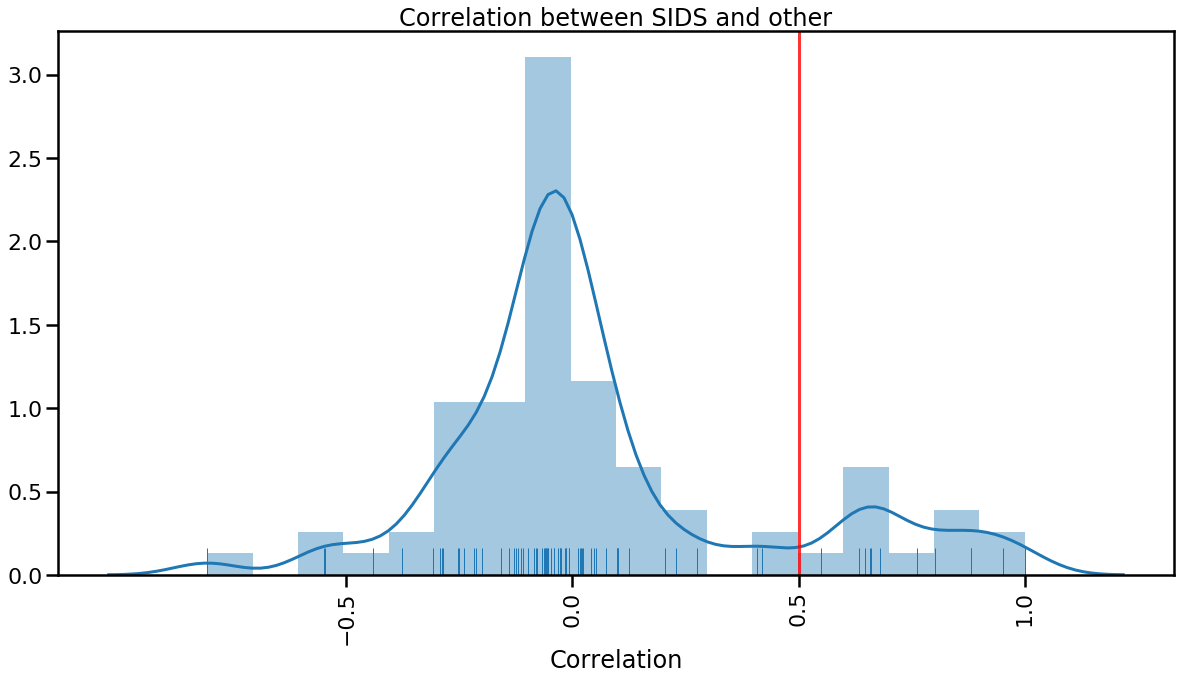

In [32]:
SIDS = frequent[frequent["DEATHCODE"] == SIDS_CODE].groupby("AGEINW").GESTAT.count()
SIDS_corr = []
cor = 0.5
for DC in popular:
    
    SIDS_corr.append((frequent[frequent["DEATHCODE"] == DC].groupby("AGEINW").GESTAT.count().corr(SIDS),DC))
    
sns.distplot([x[0] for x in SIDS_corr], rug=True)
plt.axvline(cor,color="red",alpha=0.8)
plt.title("Correlation between SIDS and other")
plt.xticks([-0.5,0,0.5,1],rotation=90)
plt.xlabel("Correlation")

SIDS_cor50 = [x[1] for x in SIDS_corr if (x[0] > cor) ]

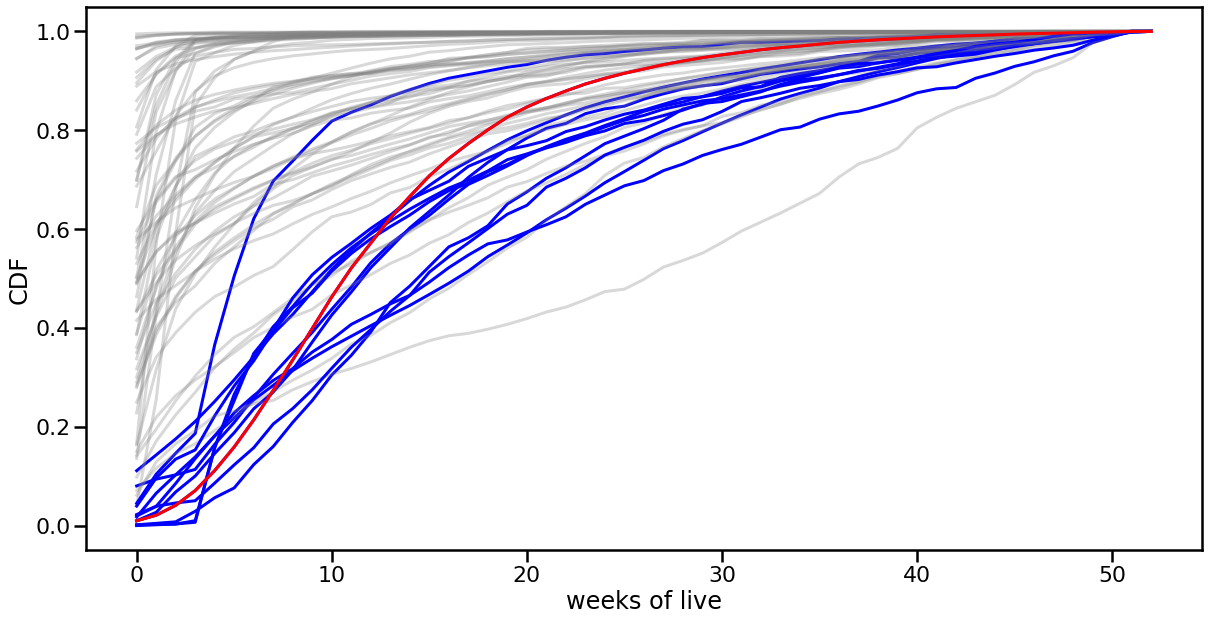

In [33]:
unstack = frequent.groupby(["DEATHCODE","AGEINW"]).DEATHCODE.count().unstack().transpose().fillna(0).cumsum(axis=0)
unstack = unstack.divide(unstack.iloc[-1])
for dc in unstack:
    if dc in SIDS_cor50:
        plt.plot(unstack[dc],color="blue")
    else:
        plt.plot(unstack[dc],color="grey",alpha = 0.3)
plt.plot(unstack[SIDS_CODE],color="red")

plt.xlabel("weeks of live")
plt.ylabel("CDF")
plt.show()

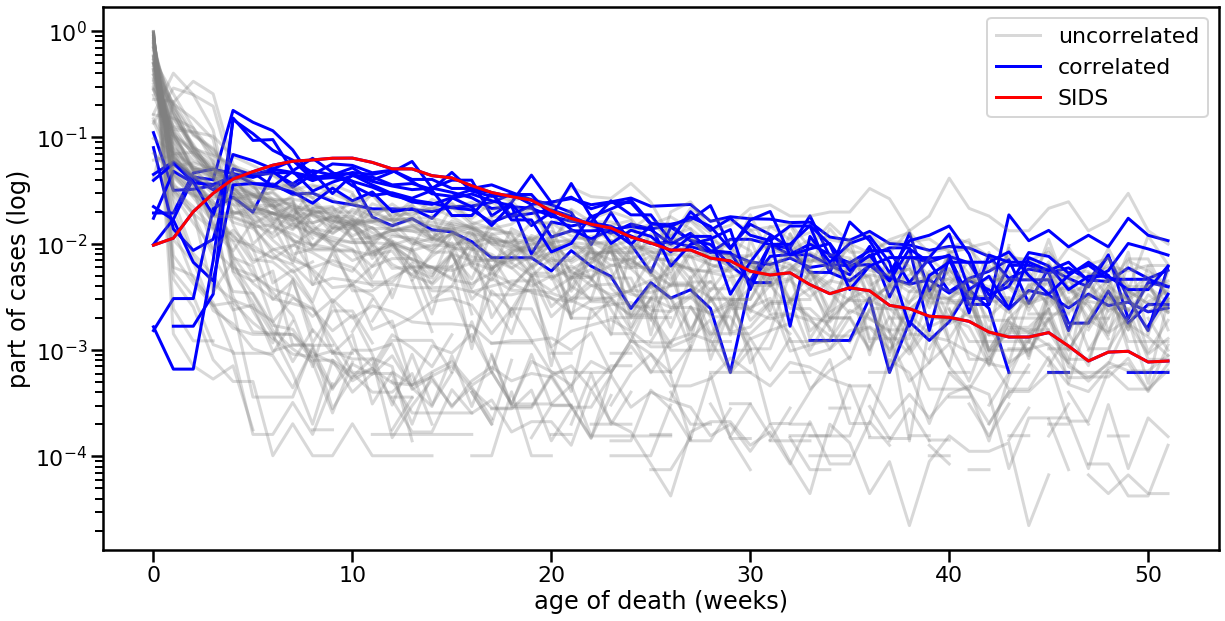

In [34]:
unstack2 = frequent.groupby(["DEATHCODE","AGEINW"]).DEATHCODE.count().unstack().transpose()
unstack2 = unstack2.divide(unstack2.sum())
for dc in unstack2:
    if dc in SIDS_cor50:
        plt.plot(unstack2[dc][:-1],color="blue",label=dc)
    else:
        plt.plot(unstack2[dc][:-1],color="grey",alpha = 0.3,label=dc)
plt.plot(unstack2[SIDS_CODE][:-1],color="red",label=SIDS_CODE)
plt.xlabel("age of death (weeks)")
plt.ylabel("part of cases (log)")
plt.yscale("log")
plt.legend(handles=[plt.gca().get_lines()[0], plt.gca().get_lines()[10],plt.gca().get_lines()[-1]]
          ,labels=["uncorrelated","correlated","SIDS"])
plt.show()

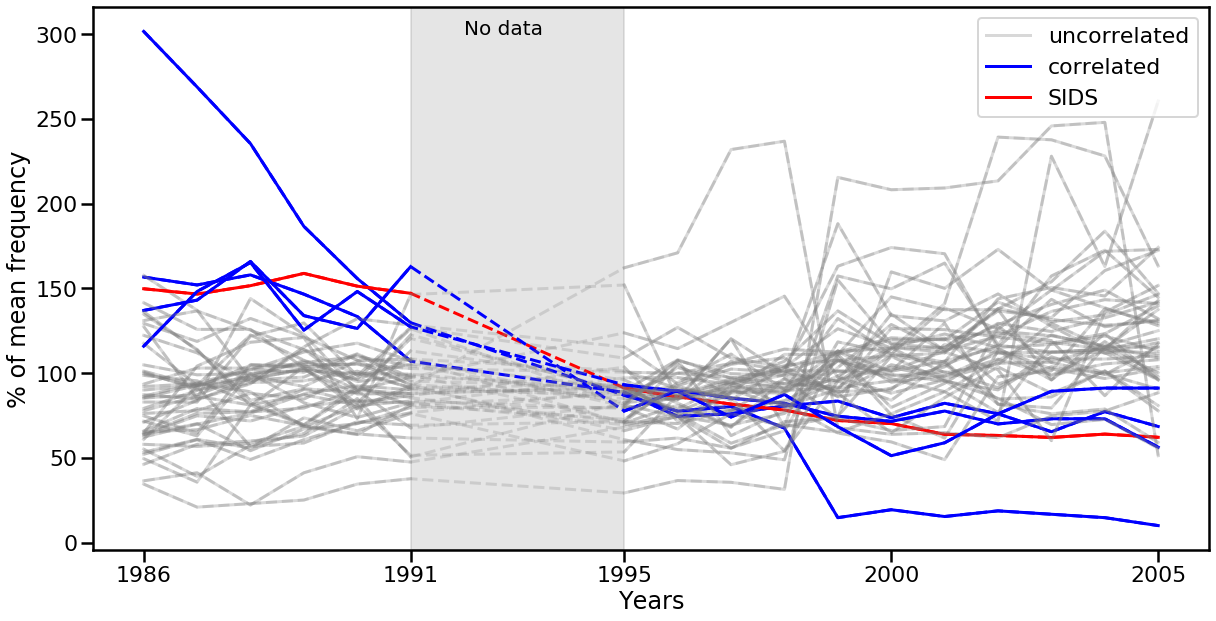

In [37]:
import scipy
for dc in unstack2:
    my= frequent[(frequent["DEATHCODE"] == dc )].groupby("BIRYR")["GESTAT"].count().mean()
    sids = [r*100/frequent[(frequent["DEATHCODE"] == SIDS_CODE )].groupby("BIRYR")["GESTAT"].count().mean() for r in frequent[(frequent["DEATHCODE"] == SIDS_CODE )].groupby("BIRYR")["GESTAT"].count()]
    cor, pval = scipy.stats.pearsonr(sids,[r*100/my for r in frequent[(frequent["DEATHCODE"] == dc )].groupby("BIRYR")["GESTAT"].count()])
    df = frequent[(frequent["DEATHCODE"] == dc )].groupby("BIRYR")["GESTAT"].count()

    all_years = np.arange(1986, 2006)
    missing_years = list(set(all_years) - set(df.index))
    for year in missing_years:
        df.loc[year] = np.nan


    df.sort_index(inplace=True)

    data=df*100/my

    if cor > 0 and pval < 0.05:
   
        if dc != SIDS_CODE:
            if dc in SIDS_cor50:

                plt.plot(data,label=dc,color="blue")
                plt.plot(data.interpolate(),label=dc,linestyle="--",color="blue")

        else:
            
            plt.plot(data,label=dc,color="red")
            plt.plot(data.interpolate(),label=dc,linestyle="--",color="red")
    
    else:
        plt.plot(data,label=dc,color="grey",alpha = 0.3)
        plt.plot(data.interpolate(),label=dc,linestyle="--",color="grey",alpha = 0.25)

plt.axvspan(1991,1995,color="grey",alpha=0.2)
plt.xlabel("Years")
plt.ylabel("% of mean frequency")
plt.legend(handles=[plt.gca().get_lines()[0], plt.gca().get_lines()[20],plt.gca().get_lines()[34]]
           ,labels=["uncorrelated","correlated","SIDS"],loc ='upper right')
plt.xticks([1986, 1991, 1995,  2000,  2005])
plt.text(1992,300,"No data", fontsize="small")
plt.show()

In [38]:
freq_codes = [(z,list(icd10_table[icd10_table["DEATHCODE"] == z]["icd10"])) for z in frequent.DEATHCODE.unique()]

descriptions = {}
for name,code_list in freq_codes:
    print("--------")
    print(name)
    descriptions[name] = {}
    for code in code_list:
        info = {"Description":""}
        if len(code) == 3:
            try:
                req = requests.get("http://icd10api.com/?code="+code+"&desc=long&r=json")
                info["Description"] = req.json()["Description"]
            except:
                print(name,code,"BLAD Pobrania")
                continue
        elif len(code) == 4:
            try:
                req = requests.get("http://icd10api.com/?code="+code+"&desc=long&r=json")
                info["Description"] = req.json()["Description"]
            except:
                try:
                    req = requests.get("http://icd10api.com/?code="+code[:-1]+"&desc=long&r=json")
                    info["Description"] = req.json()["Description"]
                except:
                    print(name,code,"BLAD Pobrania typu")
                    continue
        else:
            print(name,code,"BLAD ICD number")
            continue
        descriptions[name][code] = info["Description"]
        print(descriptions[name][code])

--------
1.0
Primary atelectasis of newborn
--------
2.0
Other low birth weight newborn
Extremely low birth weight newborn
Preterm [premature] newborn [other]
--------
3.0
Other respiratory distress of newborn
Respiratory failure of newborn
Hyperventilation
Neonatal aspiration of milk and regurgitated food
Other disorders of lung
Other specified respiratory conditions of newborn
Acute respiratory distress syndrome
Acute respiratory failure
Respiratory distress of newborn, unspecified
Other abnormalities of breathing
Primary sleep apnea of newborn
Respiratory failure, unspecified
Dyspnea
Chronic respiratory failure
Other apnea of newborn
--------
4.0
Newborn affected by multiple pregnancy
--------
5.0
Neonatal cardiac dysrhythmia
Transient myocardial ischemia in newborn
Other disorders of muscle tone of newborn
Newborn affected by other maternal conditions
Neonatal hypertension
Neonatal cardiac failure
Congenital renal failure
Cardiovascular disorder originating in the perinatal period,

Anomalous portal venous connection
Other specified congenital malformations of peripheral vascular system
Arteriovenous malformation (peripheral)
--------
105.0
Newborn affected by incompetent cervix
--------
108.0
Other reduction deformities of brain
Arhinencephaly
Congenital malformations of corpus callosum
Holoprosencephaly
--------
109.0
Common arterial trunk
--------
111.0
Sepsis, unspecified organism
--------
121.0
Congenital malformation, unspecified
--------
122.0
Other congenital malformations of aortic and mitral valves
Congenital malformation of aortic and mitral valves, unspecified
Other specified congenital malformations of heart
Congenital heart block
Malformation of coronary vessels
Cor triatriatum
Dextrocardia
Congenital subaortic stenosis
--------
129.0
Mandibulofacial dysostosis
Other specified congenital malformations of skull and face bones
Other congenital malformations of musculoskeletal system
Macrocephaly
Congenital malformation syndromes predominantly affecting

In [46]:
descriptions[39.0] = {"R95":"SIDS"}

In [49]:
from scipy.stats import linregress

gest_ageinw_corr_list = []

for deathcode in frequent.groupby("DEATHCODE"):
    dc_data = deathcode[1]
    ling = linregress(dc_data['GESTAT'], dc_data['AGEINW'])
    if ling[0] < 0 and ling[3] < 0.05:
        gest_ageinw_corr_list.append(deathcode[0])
        print(deathcode[0], descriptions[deathcode[0]])
        print(ling)
        print(list(icd9_table[icd9_table["DEATHCODE"] == deathcode[0]]["icd9"]))
        print(list(icd10_table[icd10_table["DEATHCODE"] == deathcode[0]]["icd10"]))

39.0 {'R95': 'SIDS'}
LinregressResult(slope=-0.02199973441943659, intercept=13.855122826283484, rvalue=-0.027626370742091566, pvalue=1.5079776277386463e-11, stderr=0.0032599700695577533)
['7980', '7989']
['R95']
41.0 {'J210': 'Acute bronchiolitis due to respiratory syncytial virus', 'J218': 'Acute bronchiolitis due to other specified organisms', 'J219': 'Acute bronchiolitis, unspecified'}
LinregressResult(slope=-0.09683031944323121, intercept=21.211929662048, rvalue=-0.09169181837088577, pvalue=0.01882757672104797, stderr=0.04112051505769203)
['4661']
['J210', 'J218', 'J219']
86.0 {'P248': 'Other neonatal aspiration', 'P241': 'Neonatal aspiration of (clear) amniotic fluid and mucus', 'P249': 'Neonatal aspiration, unspecified', 'P242': 'Neonatal aspiration of blood', 'P240': 'Meconium aspiration'}
LinregressResult(slope=-0.021478309642151135, intercept=1.959879583649843, rvalue=-0.0623513753209544, pvalue=0.01199040635094913, stderr=0.008539190591845236)
['7701']
['P248', 'P241', 'P249'

(28308, 17)
(13482, 17)
(12886, 17)


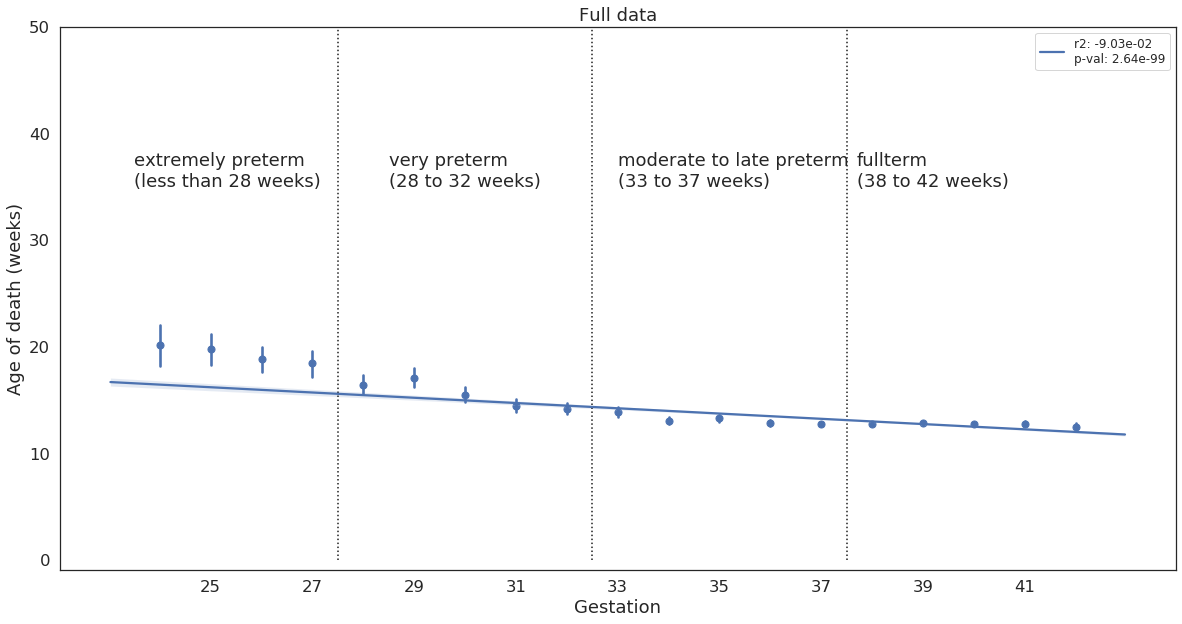

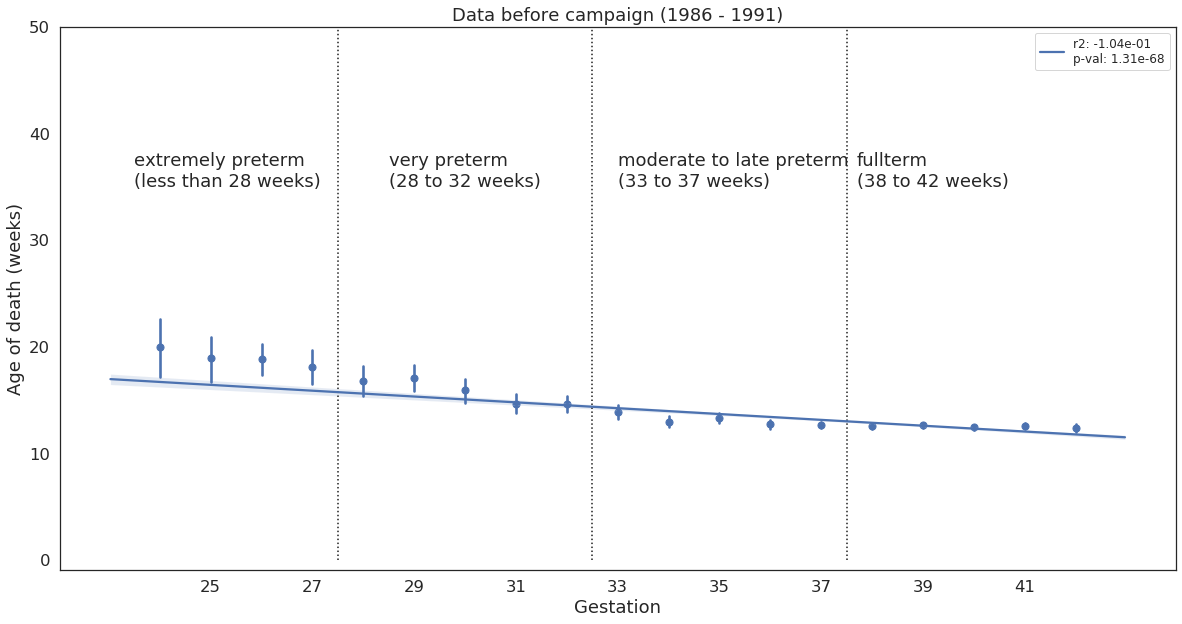

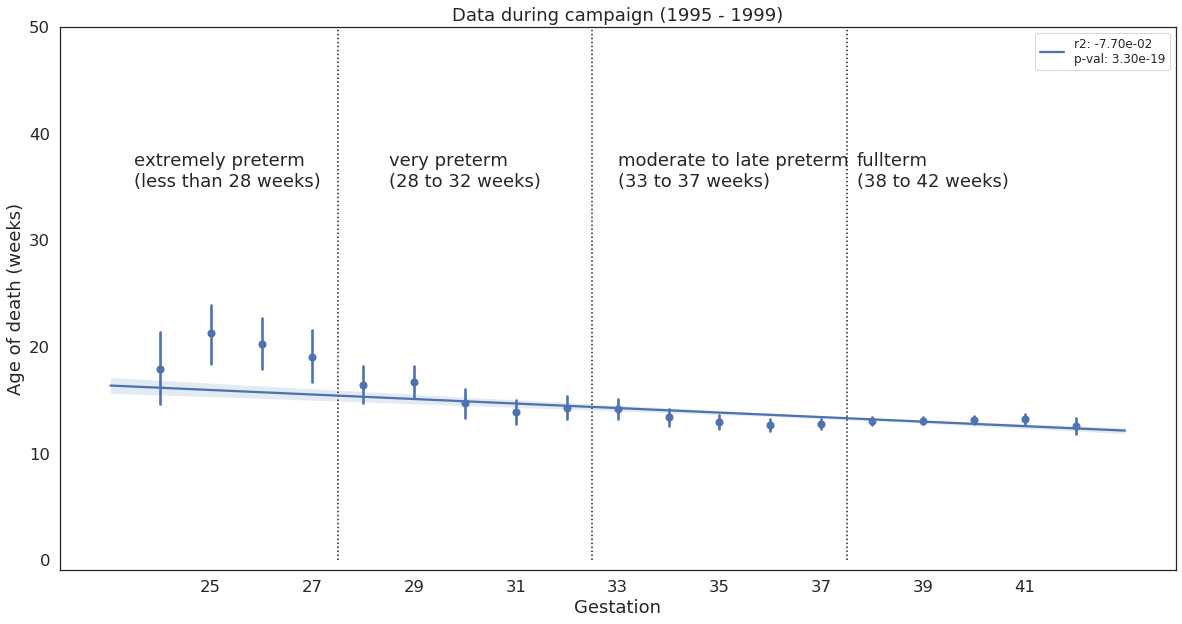

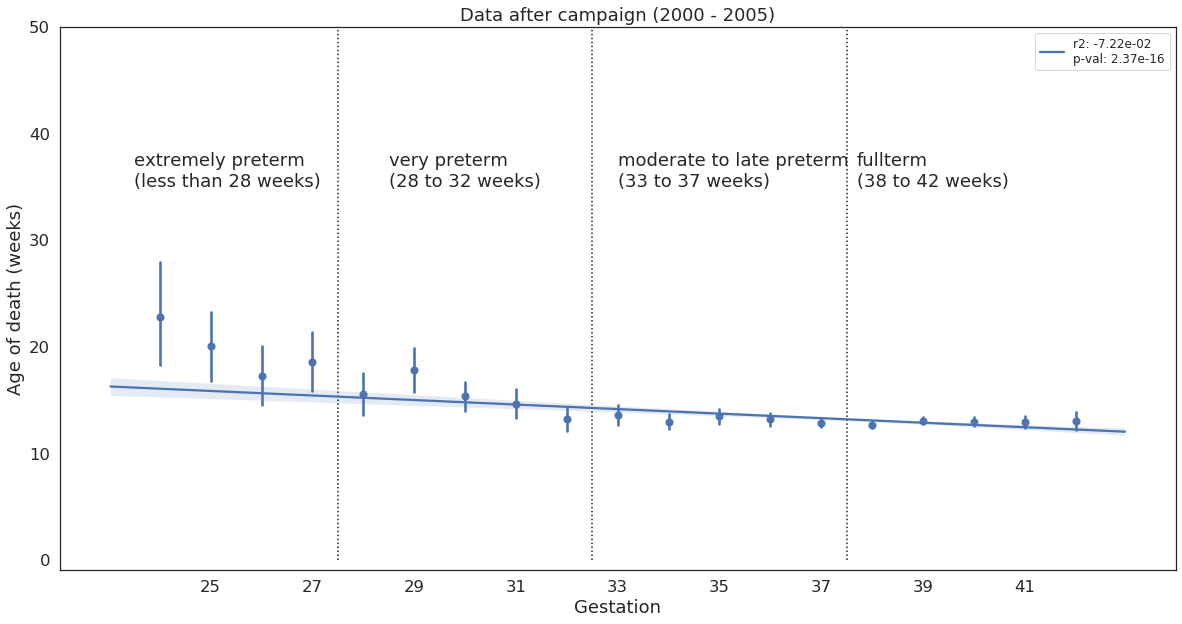

(225, 17)
(196, 17)
(195, 17)


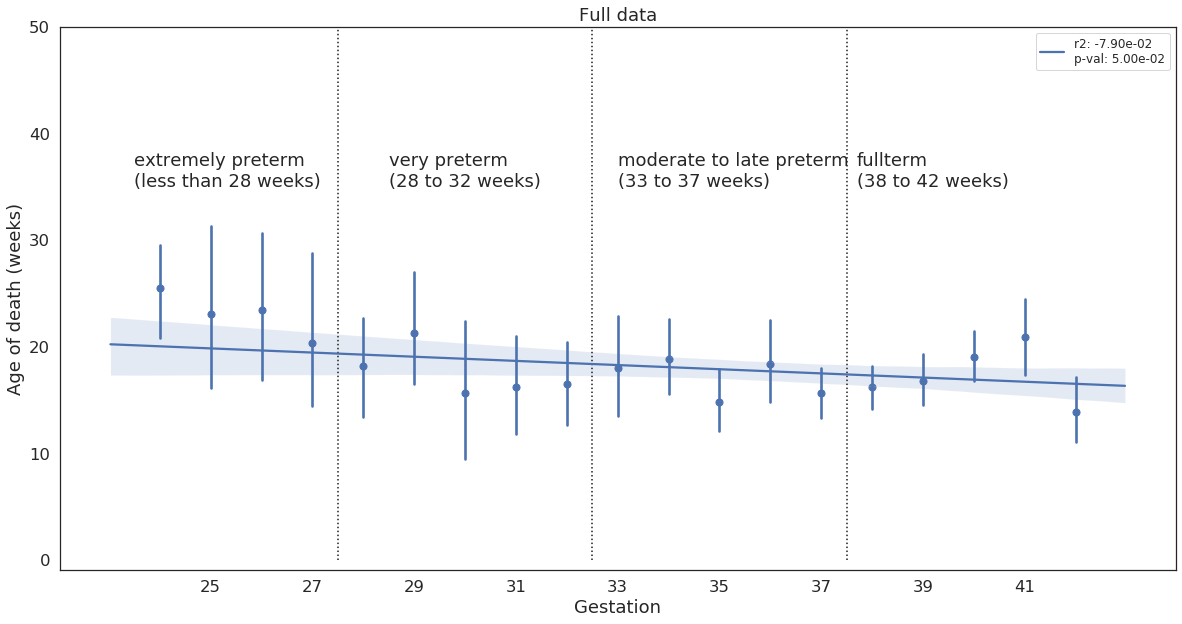

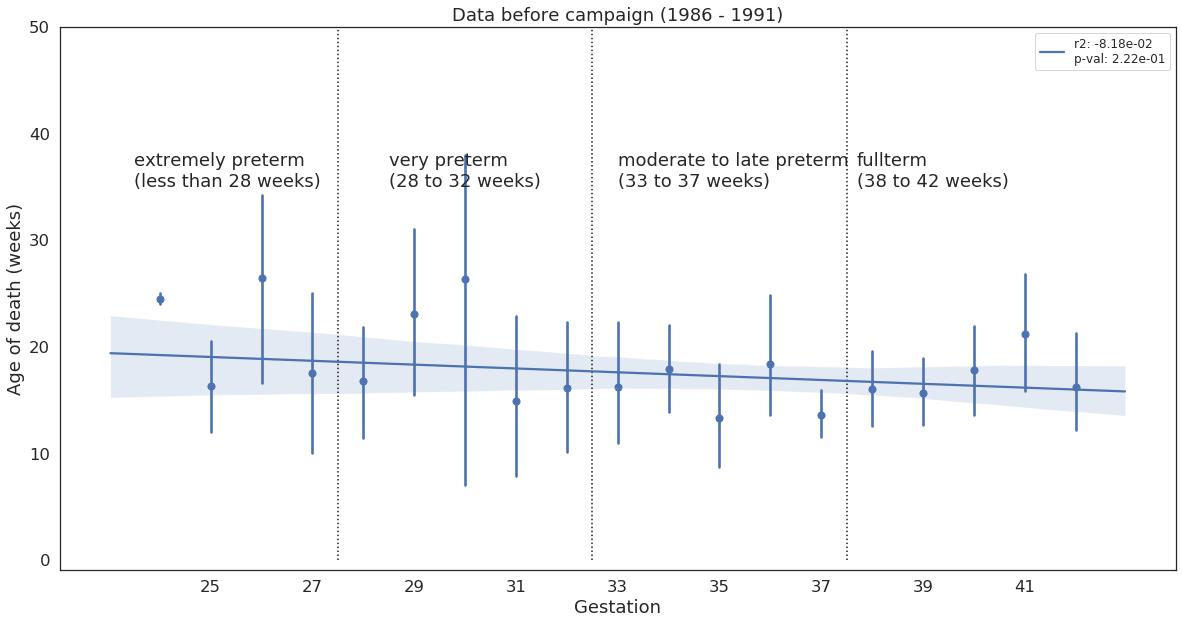

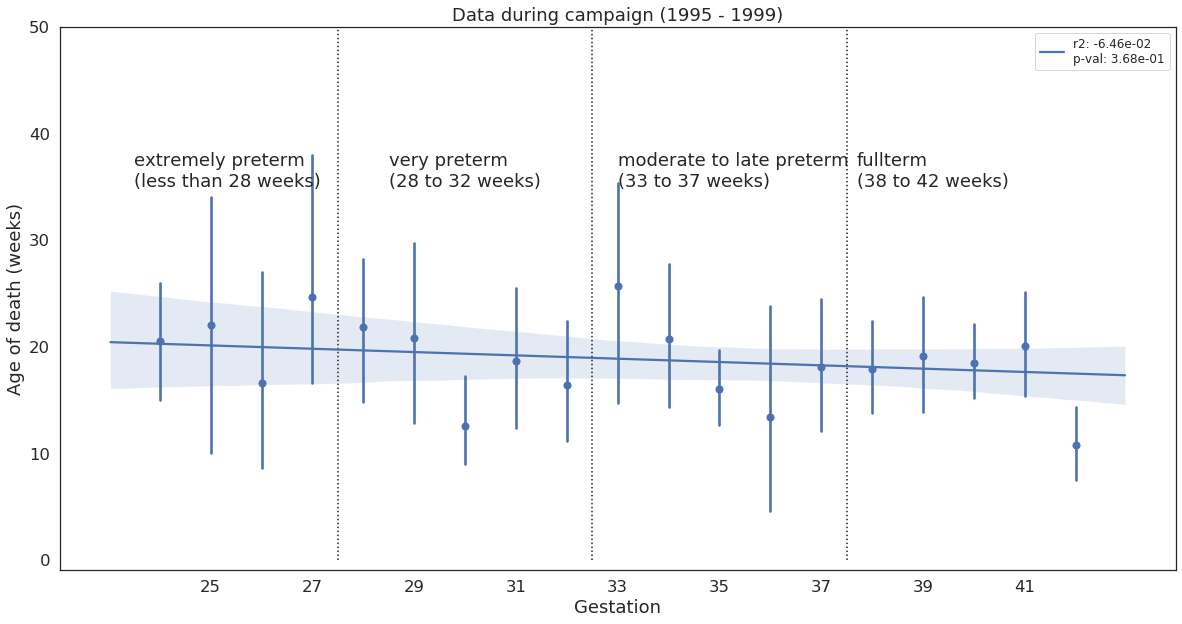

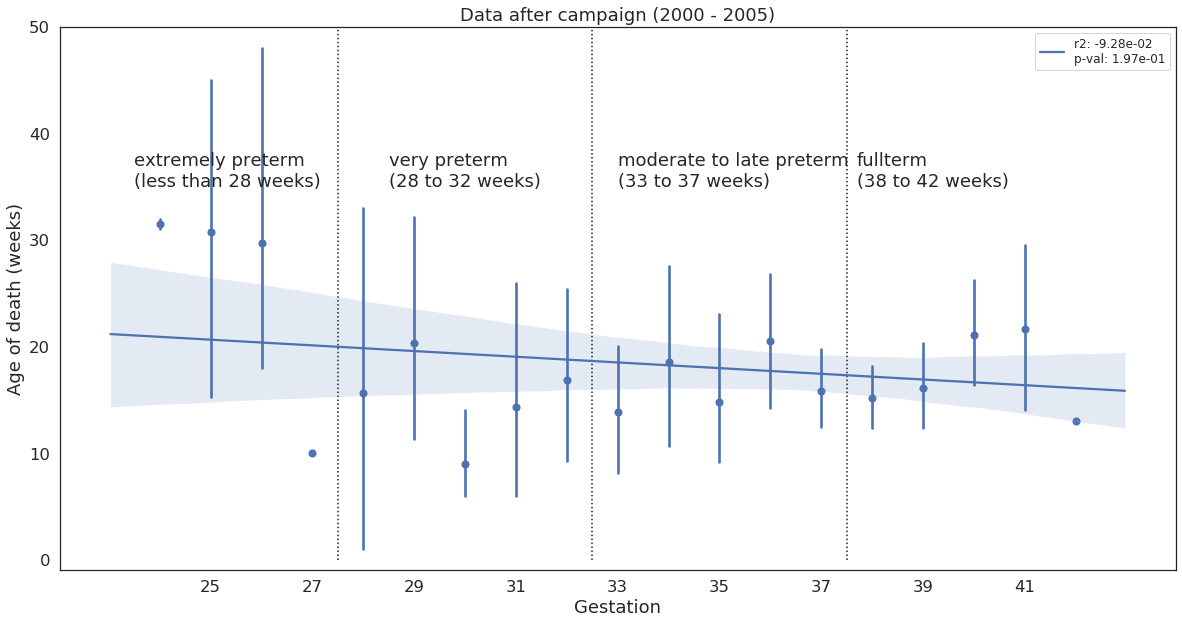

(799, 17)
(298, 17)
(284, 17)


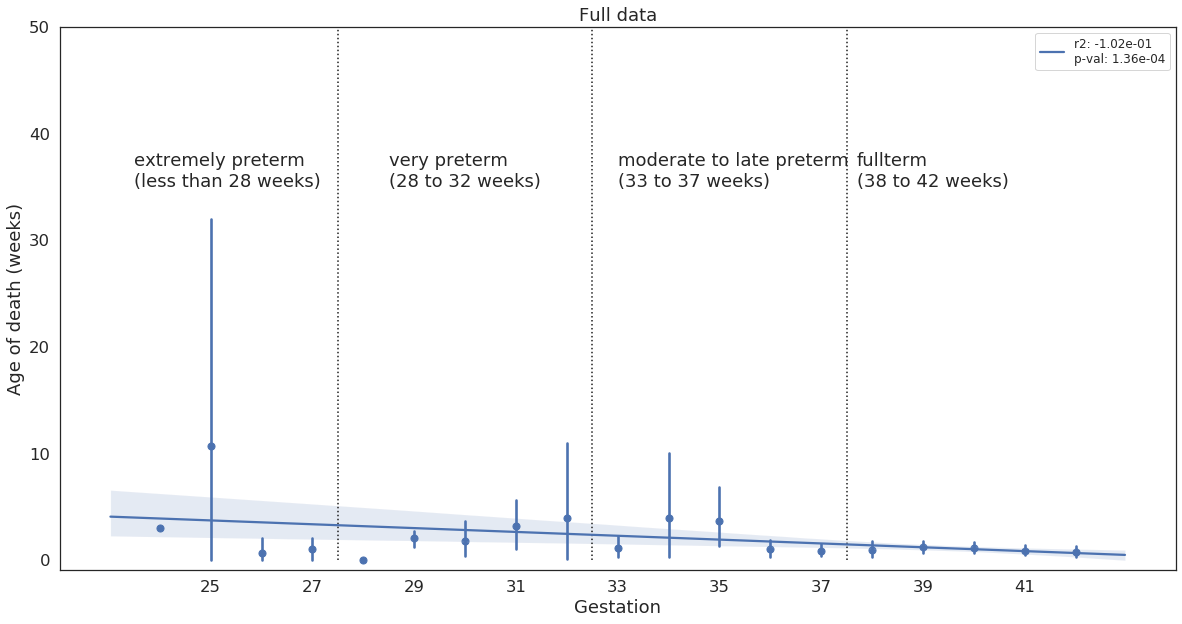

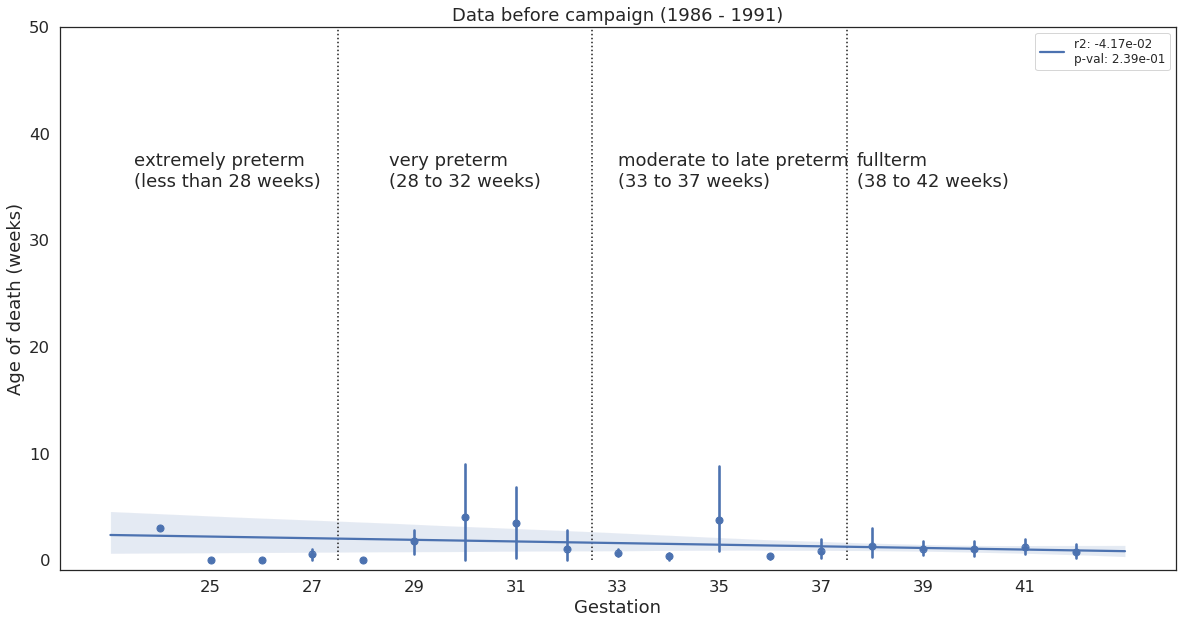

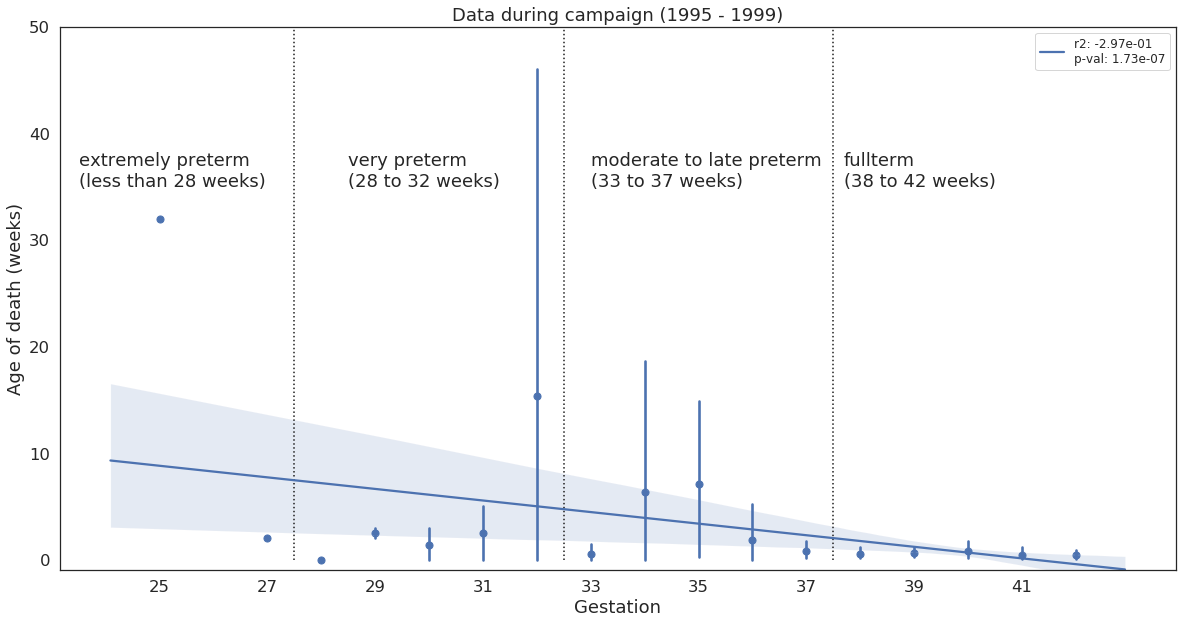

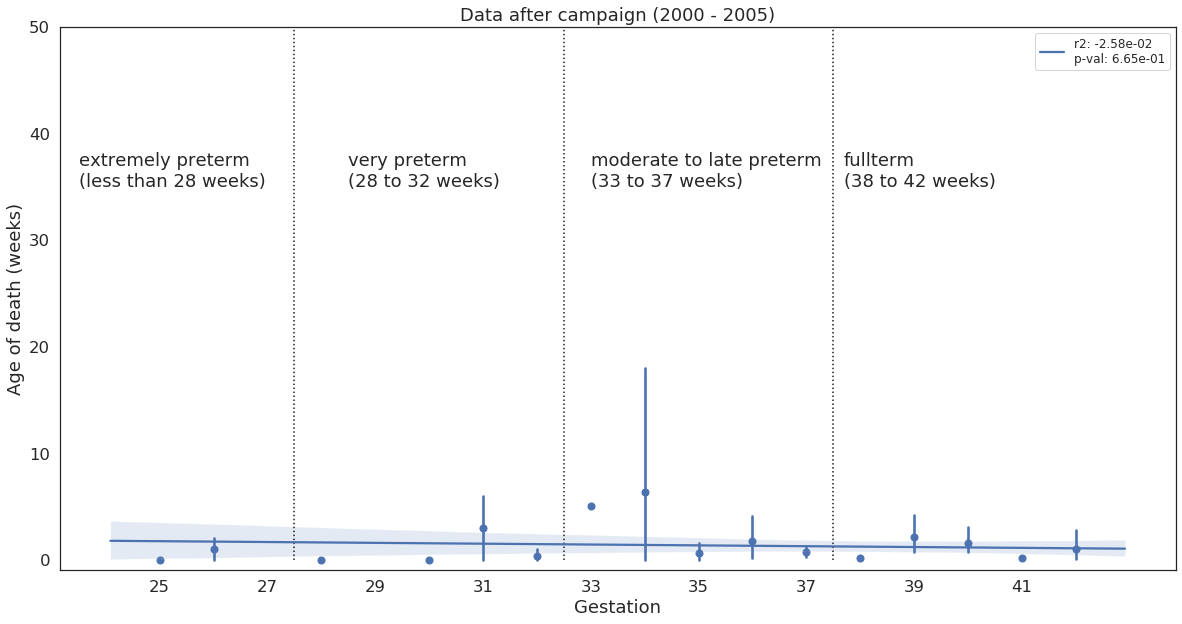

(1936, 17)
(1488, 17)
(2216, 17)


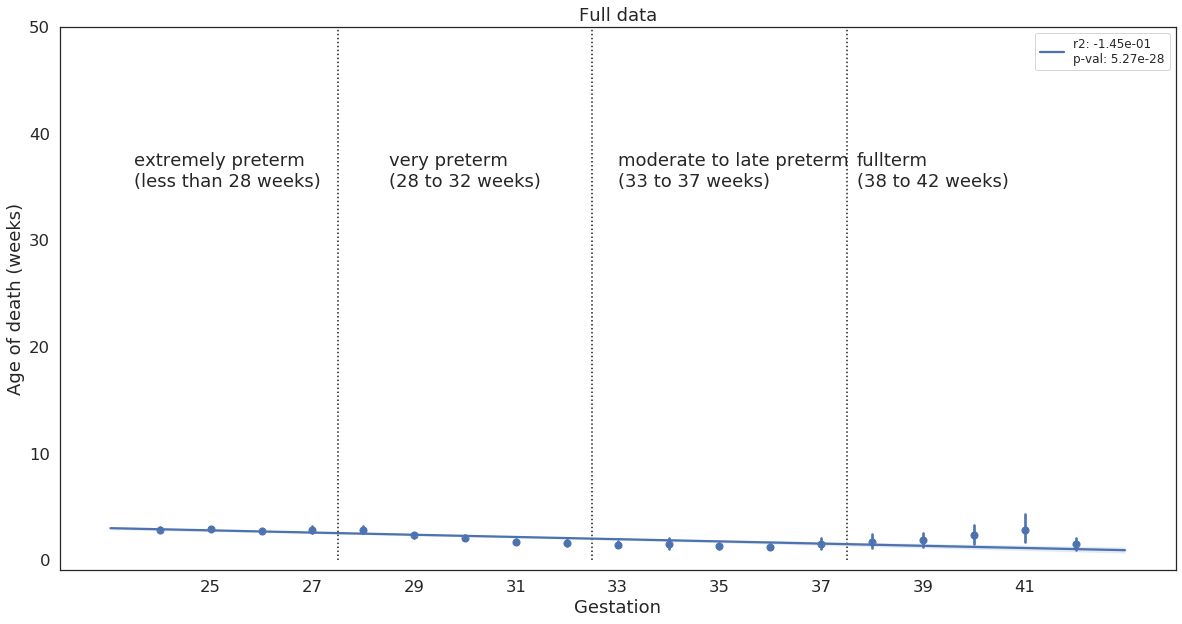

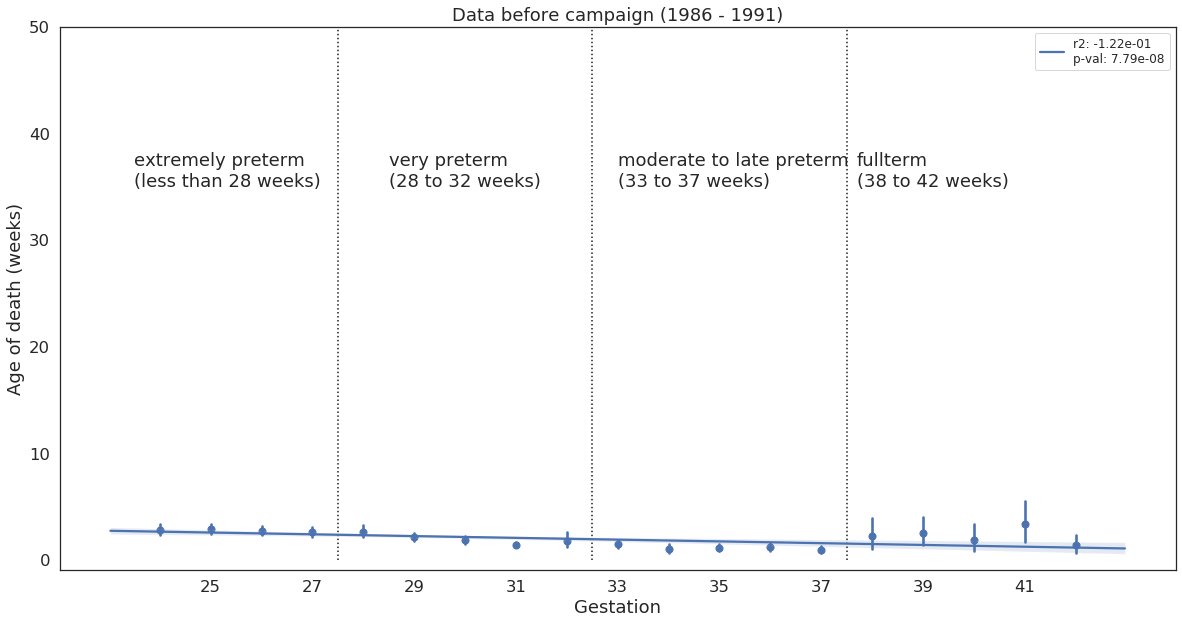

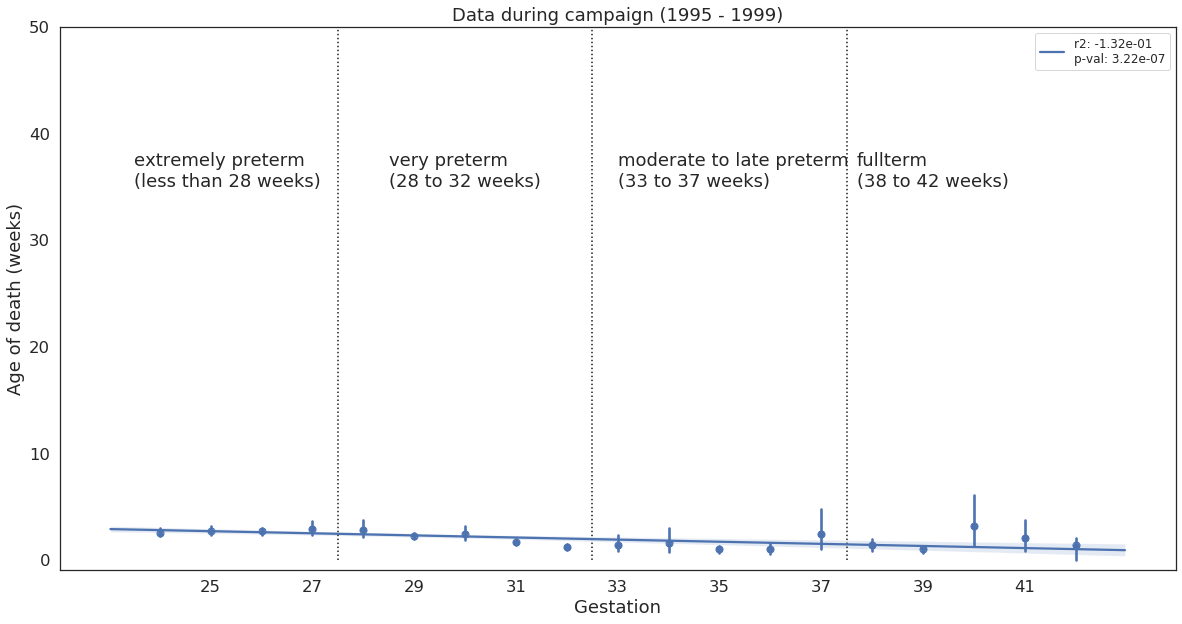

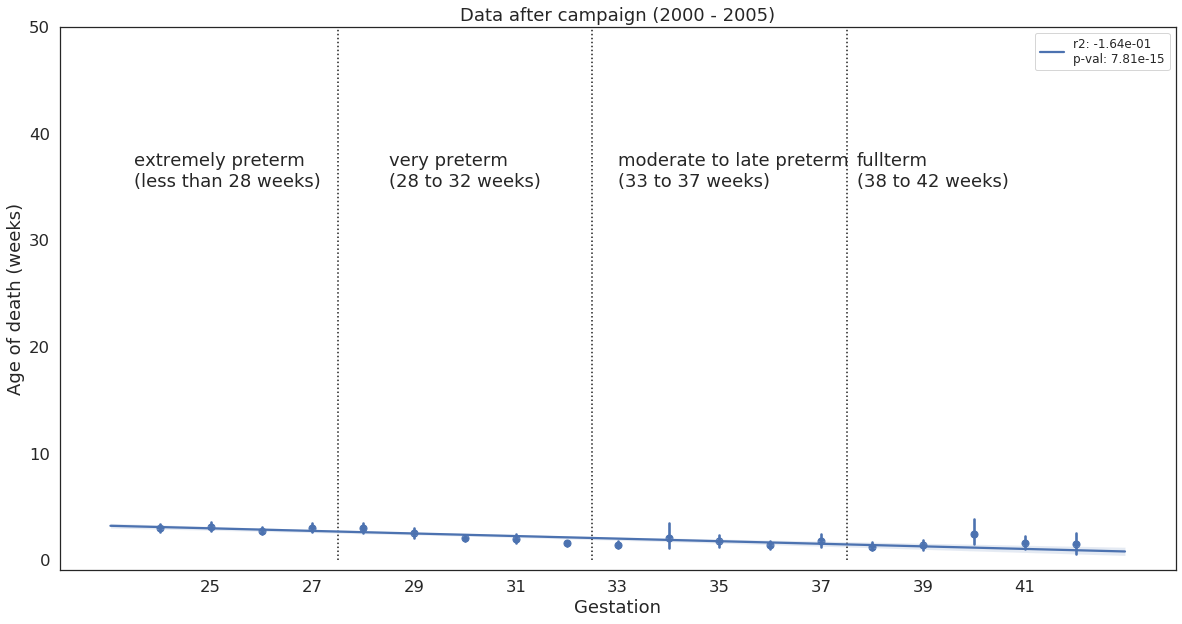

In [55]:
import scipy.stats as stats

for code in gest_ageinw_corr_list:
    working_data1 = frequent[(frequent["DEATHCODE"]==code)&(frequent["GESTAT"] > 23) & (frequent["GESTAT"] < 43)]
    working_data_BEFORE = working_data1[(working_data1["BIRYR"] < 1994)]
    print(working_data_BEFORE.shape)

    working_data_DURING = working_data1[(working_data1["BIRYR"] > 1994)&(working_data1["BIRYR"] < 2000)]
    print(working_data_DURING.shape)

    working_data_AFTER = working_data1[(working_data1["BIRYR"] >= 2000)]
    print(working_data_AFTER.shape)

    sns.set_context("paper")
    sns.set(font_scale=1.5)
    sns.set_style("white")
    datasets = [working_data1,working_data_BEFORE,working_data_DURING,working_data_AFTER]
    titles = ["Full data", "Data before campaign (1986 - 1991)",
              "Data during campaign (1995 - 1999)", "Data after campaign (2000 - 2005)"]

    from matplotlib import rcParams
    #rcParams['figure.figsize'] = 20,10

    for i,w_data in enumerate(datasets):
        r,p = stats.pearsonr(w_data['GESTAT'], w_data['AGEINW'])

        sns.regplot(x="GESTAT",y="AGEINW", data = w_data,x_estimator=np.mean,  fit_reg=True,
                    line_kws={'label':"r2: "+'{:.2e}'.format(r)+"\np-val: "+'{:.2e}'.format(p)})

        #plt.vlines([27.5,32.5,37.5],10,28.5,linestyles="dotted")
        plt.vlines([27.5,32.5,37.5],0,50,linestyles="dotted")
        plt.legend(fontsize=12)
        plt.xlabel("Gestation")
        plt.ylabel("Age of death (weeks)")
        plt.title(titles[i])
        plt.ylim(-1,50)
        plt.xticks([25,27,29,31,33,35,37,39,41])
        plt.text(23.5,35,"extremely preterm \n(less than 28 weeks)")
        plt.text(28.5,35,"very preterm\n(28 to 32 weeks)")
        plt.text(33,35,"moderate to late preterm\n(33 to 37 weeks)")
        plt.text(37.7,35,"fullterm\n(38 to 42 weeks)")
        plt.show()
